In [133]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:


import pandas as pd
import os
import datetime
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import climetlab as cml
import cfgrib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob import glob


#SD
from mymetrics import compute_rmse, compute_mae, compute_bias, compute_acc
from data_utils import extract_temp_pressure_level, process_and_combine
#SD

In [135]:
data_dir = '/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/ai-models/data/forecast_data/'
fcn_dir = '/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/ai-models/data/forecast_data/fourcastnet'
pangu_dir = '/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/ai-models/data/forecast_data/pangu'
graphcast_dir = '/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/ai-models/data/forecast_data/graphcast'

india_era5_6_days_12_steps = '/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/my_graphcast_dir/data/era5_data/indian_region_era5_date-2022-01-01_res-0.25_levels-13_steps-12.nc'

india_era5_6_days_6days = '/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/my_graphcast_dir/data/era5_data/cds-era5-india-20220101-6days.grib'

In [136]:
lead_time = 48      # hours
init_time = 20220101 # yyyymmdd
start_time = '00'
variables = ['t']    # t: temperature
pressure_levels = [500] # 500 hPa corresponds to approx 5 km above sea level
models = ['FCN', 'pangu'] # neuralgcm

# India specific
lat_min, lat_max = 8.0, 37.0
lon_min, lon_max = 68.0, 97.0

In [137]:
current_pangu_dir = f"{pangu_dir}/init{init_time}-lead{lead_time}-t{start_time}-pangu"
current_fcn_dir = f"{fcn_dir}/init{init_time}-lead{lead_time}-t{start_time}-fcn"

pangu0 = f"{pangu_dir}/init{init_time}-lead{lead_time}-t{start_time}-pangu/out-pangu-0.grib"
fcn0 = f"{fcn_dir}/init{init_time}-lead{lead_time}-t{start_time}-fcn/out-FCNv2-0.grib"


In [141]:
pangu42 = xr.open_dataset(f'{current_pangu_dir}/out-pangu-all42.nc')
fcn42 = xr.open_dataset(f'{current_fcn_dir}/out-fcn-all42.nc')
fcn42

<xarray.Dataset> Size: 33MB
Dimensions:        (step: 8, latitude: 721, longitude: 1440)
Coordinates:
    time           datetime64[ns] 8B ...
  * step           (step) timedelta64[ns] 64B 00:00:00 ... 1 days 18:00:00
    isobaricInhPa  float64 8B ...
  * latitude       (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    valid_time     (step) datetime64[ns] 64B ...
Data variables:
    t              (step, latitude, longitude) float32 33MB ...

In [144]:
india_era42 = xr.open_dataset(india_era5_6_days_12_steps)
india_era42 = india_era42.sel(
    lat=slice(lat_min, lat_max),
    lon=slice(lon_min, lon_max)
)
india_era42

<xarray.Dataset> Size: 65MB
Dimensions:                       (lon: 117, lat: 117, time: 14, level: 13,
                                   batch: 1)
Coordinates:
  * lon                           (lon) float32 468B 68.0 68.25 ... 96.75 97.0
  * lat                           (lat) float32 468B 8.0 8.25 8.5 ... 36.75 37.0
  * time                          (time) timedelta64[ns] 112B 0 days 00:00:00...
  * level                         (level) int32 52B 50 100 150 ... 850 925 1000
    datetime                      (batch, time) datetime64[ns] 112B ...
Dimensions without coordinates: batch
Data variables: (12/14)
    geopotential_at_surface       (lat, lon) float32 55kB ...
    land_sea_mask                 (lat, lon) float32 55kB ...
    2m_temperature                (batch, time, lat, lon) float32 767kB ...
    mean_sea_level_pressure       (batch, time, lat, lon) float32 767kB ...
    10m_v_component_of_wind       (batch, time, lat, lon) float32 767kB ...
    10m_u_component_of_wind       (batch, time, lat, lon) float32 767kB ...
    ...                            ...
    temperature                   (batch, time, level, lat, lon) float32 10MB ...
    geopotential                  (batch, time, level, lat, lon) float32 10MB ...
    u_component_of_wind           (batch, time, level, lat, lon) float32 10MB ...
    v_component_of_wind           (batch, time, level, lat, lon) float32 10MB ...
    vertical_velocity             (batch, time, level, lat, lon) float32 10MB ...
    specific_humidity             (batch, time, level, lat, lon) float32 10MB ...

In [129]:
# for each time step in india_fcn120, plot the 't' variable at 500 hpa. Note that the step variable is in ns, so while iterating over hours you need to convert that to hours
for step in range(20):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    
    india_fcn120['t'].isel(step=step, isobaricInhPa=1).plot(ax=axes[0], cmap='coolwarm')
    axes[0].set_title(f'FCN Step {step}')
    
    india_pangu120['t'].isel(step=step, isobaricInhPa=1).plot(ax=axes[1], cmap='coolwarm')
    axes[1].set_title(f'Pangu Step {step}')
    
    india_era5_6_days['t'].isel(time=step, isobaricInhPa=1).plot(ax=axes[2], cmap='coolwarm')
    axes[2].set_title(f'ERA5 Step {step}')
    
    plt.savefig(f'/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/ai-models/src/ai_models/results/20220101-120hrs/fcn_pangu_era5/plot_step_{step}.png')
    # plt.show()
    plt.close(fig)


In [130]:
results_path = f'/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/ai-models/src/ai_models/results/20220101-120hrs/fcn_pangu_era5'

RMSE values for FCN: [3.8900726, 3.9441247, 4.0999026, 3.8143919, 3.5872276, 3.7843668, 4.165575, 3.7420657, 3.6111286, 3.9522092, 4.1943054, 3.778546, 3.489547, 3.756766, 4.075319, 3.6679304, 3.4170997, 3.6567688, 4.0428267, 3.5100038]
RMSE values for Pangu: [3.8900726, 4.016207, 4.3031664, 4.0725975, 3.745642, 4.157757, 4.502328, 4.179693, 3.9158063, 4.417828, 4.613307, 4.2549796, 3.859311, 4.557592, 4.773937, 4.4591765, 4.1652546, 4.780423, 5.0298843, 4.698438]


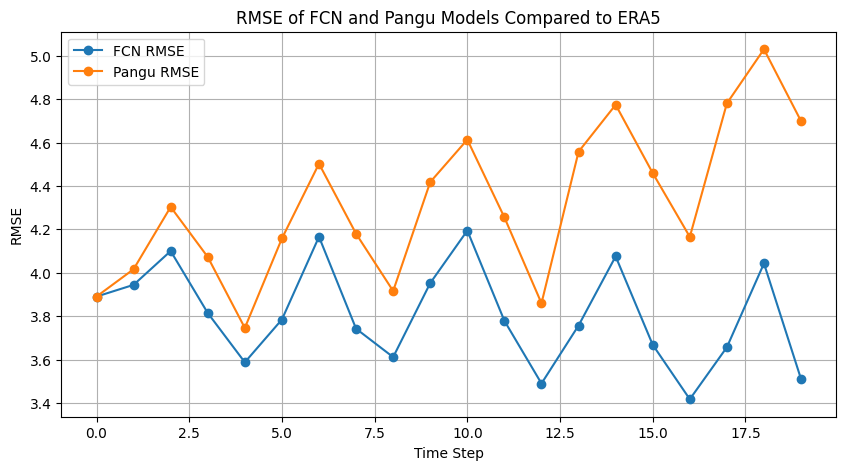

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Function to compute RMSE
def compute_rmse(pred, true):
    return np.sqrt(mean_squared_error(true, pred))

# Initialize lists to store RMSE values
rmse_values_fcn = []
rmse_values_pangu = []

# Iterate over each time step
for step in range(20):
    # Extract temperature at 500 hPa for each model and ERA5
    temp_fcn = india_fcn120['t'].isel(step=step, isobaricInhPa=1).values
    temp_pangu = india_pangu120['t'].isel(step=step, isobaricInhPa=1).values
    temp_era5 = india_era5_6_days['t'].isel(time=step, isobaricInhPa=1).values
    
    # Compute RMSE for FCN and Pangu compared to ERA5
    rmse_fcn = compute_rmse(temp_fcn, temp_era5)
    rmse_pangu = compute_rmse(temp_pangu, temp_era5)
    
    # Append RMSE values to the lists
    rmse_values_fcn.append(rmse_fcn)
    rmse_values_pangu.append(rmse_pangu)

# Print RMSE values
print("RMSE values for FCN:", rmse_values_fcn)
print("RMSE values for Pangu:", rmse_values_pangu)
# Plot RMSE values
plt.figure(figsize=(10, 5))
plt.plot(range(20), rmse_values_fcn, label='FCN RMSE', marker='o')
plt.plot(range(20), rmse_values_pangu, label='Pangu RMSE', marker='o')
plt.xlabel('Time Step')
plt.ylabel('RMSE')
plt.title('RMSE of FCN and Pangu Models Compared to ERA5')
plt.legend()
plt.grid(True)
plt.show()
# Compute and plot the difference in temperature at 500 hPa for FCN and Pangu relative to ERA5
for step in range(20):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    diff_fcn = india_fcn120['t'].isel(step=step, isobaricInhPa=1) - india_era5_6_days['t'].isel(time=step, isobaricInhPa=1)
    diff_pangu = india_pangu120['t'].isel(step=step, isobaricInhPa=1) - india_era5_6_days['t'].isel(time=step, isobaricInhPa=1)
    
    diff_fcn.plot(ax=axes[0], cmap='coolwarm')
    axes[0].set_title(f'FCN - ERA5 Step {step}')
    
    diff_pangu.plot(ax=axes[1], cmap='coolwarm')
    axes[1].set_title(f'Pangu - ERA5 Step {step}')
    
    plt.savefig(f'/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/ai-models/src/ai_models/results/20220101-120hrs/fcn_pangu_era5/diff_plot_step_{step}.png')
    plt.close(fig)

# weird results are coming compared to the 42 hours thing since era5 data is taking every 6 hours while the graphcast era5 ground truth was originally hourly and then aggregated to 6 hours

In [132]:
for model in models:
    for level in pressure_levels:
        for var in variables:
            if model == 'FCN':
                model = 'FCNv2'
                forecast_path = os.path.join(fcn_dir, 'init20220101-lead120-t00-fcn')
            elif model == 'pangu':
                forecast_path = os.path.join(pangu_dir, 'init20220101-lead120-t00-pangu')
            elif model == 'graphcast':
                # all the graphcast forecast data is in one file so the processing isn't needed for that
                forecast_path = os.path.join(graphcast_dir, f'{model}_forecast_{var}_{level}hPa_{init_time}_{lead_time}.nc')
            else:
                raise ValueError('Invalid model name')
            # print(forecast_path)
            # data = xr.open_dataset(forecast_path)
            forecast_df = extract_temp_pressure_level(f'{forecast_path}/out-{model}-0.grib', var, level)
            for i in range(6, lead_time+1, 6):
                # print(f"{forecast_path}/out-{model}-{i}.grib")
                # pangu_df_temp = extract_temp_pressure_level(f"{pangu_dir}/out-pangu-{i}.grib",'t', '500')
                # pangu_df = xr.concat([pangu_df, pangu_df_temp], dim="step")
                # del pangu_df_temp
                pass